# Deeper Dive on Fitted Forests in StochTree

While out of sample evaluation and MCMC diagnostics on parametric BART components (i.e. $\sigma^2$, the global error variance) are helpful, it's important to be able to inspect the trees in a BART / BCF model (or a custom tree ensemble model). This vignette walks through some of the features `stochtree` provides to query and understand the forests / trees in a model.

Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from stochtree import BARTModel
from sklearn.model_selection import train_test_split

## Demo 1: Supervised Learning

Generate sample data where feature 1 is the only "important" feature.

In [2]:
# RNG
random_seed = 1234
rng = np.random.default_rng(random_seed)

# Generate covariates and basis
n = 1000
p_X = 10
X = rng.uniform(0, 1, (n, p_X))

# Define the outcome mean function
def outcome_mean(X):
    return np.where(
        (X[:,9] >= 0.0) & (X[:,9] < 0.25), -7.5, 
        np.where(
            (X[:,9] >= 0.25) & (X[:,9] < 0.5), -2.5, 
            np.where(
                (X[:,9] >= 0.5) & (X[:,9] < 0.75), 2.5, 
                7.5
            )
        )
    )

# Generate outcome
epsilon = rng.normal(0, 1, n)
y = outcome_mean(X) + epsilon

# Standardize outcome
y_bar = np.mean(y)
y_std = np.std(y)
resid = (y-y_bar)/y_std

Test-train split

In [3]:
sample_inds = np.arange(n)
train_inds, test_inds = train_test_split(sample_inds, test_size=0.5)
X_train = X[train_inds,:]
X_test = X[test_inds,:]
y_train = y[train_inds]
y_test = y[test_inds]

Run BART

In [4]:
bart_model = BARTModel()
param_dict = {"keep_gfr": True}
bart_model.sample(X_train=X_train, y_train=y_train, X_test=X_test, num_gfr=10, num_mcmc=100, params=param_dict)

Inspect the MCMC (BART) samples

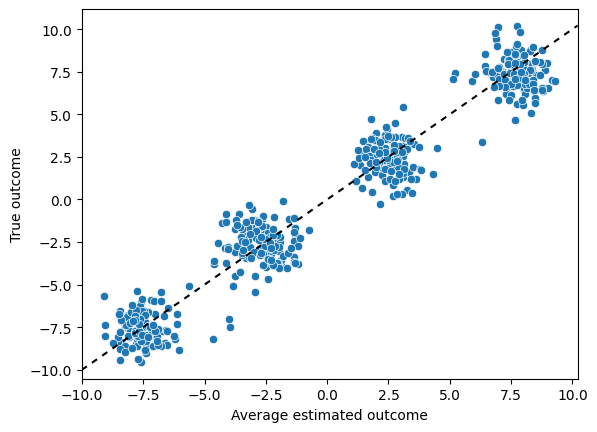

In [5]:
forest_preds_y_mcmc = bart_model.y_hat_test[:,bart_model.num_gfr:]
y_avg_mcmc = np.squeeze(forest_preds_y_mcmc).mean(axis = 1, keepdims = True)
y_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(y_test,1), y_avg_mcmc), axis = 1), columns=["True outcome", "Average estimated outcome"])
sns.scatterplot(data=y_df_mcmc, x="Average estimated outcome", y="True outcome")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (3,3)))
plt.show()

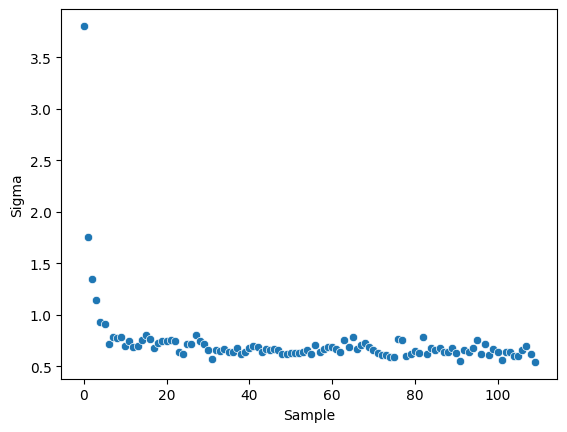

In [6]:
sigma_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(np.arange(bart_model.num_samples),axis=1), np.expand_dims(bart_model.global_var_samples,axis=1)), axis = 1), columns=["Sample", "Sigma"])
sns.scatterplot(data=sigma_df_mcmc, x="Sample", y="Sigma")
plt.show()

Compute the test set RMSE

In [7]:
np.sqrt(np.mean(np.power(y_test - np.squeeze(y_avg_mcmc),2)))

1.2873862776376062

Check the variable split count in the last "GFR" sample

In [8]:
bart_model.forest_container_mean.get_forest_split_counts(9, p_X)

array([28, 23, 23, 19, 18, 28, 35, 34, 40, 29], dtype=int32)

In [9]:
bart_model.forest_container_mean.get_overall_split_counts(p_X)

array([3199, 2738, 2626, 2031, 1976, 3262, 2024, 2764, 2891, 3670],
      dtype=int32)

The split counts appear relatively uniform across features, so let's dig deeper and look at individual trees, starting with the first tree in the last "grow-from-root" sample.

In [10]:
splits = bart_model.forest_container_mean.get_granular_split_counts(p_X)

In [11]:
splits[9,0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

This tree has a single split on the only "important" feature. Now, let's look at the second tree.

In [12]:
splits[9,1,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

This tree also only splits on the important feature.

In [13]:
splits[9,20,:]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [14]:
splits[9,30,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

We see that "later" trees are splitting on other features, but we also note that these trees are fitting an outcome that is already residualized many "relevant splits" made by trees 1 and 2.

Now, let's inspect the first tree for this last GFR sample in more depth, following [this scikit-learn vignette](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html).

In [15]:
forest_num = 9
tree_num = 0

In [16]:
nodes = np.sort(bart_model.forest_container_mean.nodes(forest_num,tree_num))
for nid in nodes:
  if bart_model.forest_container_mean.is_leaf_node(forest_num,tree_num,nid):
    print(
      "{space}node={node} is a leaf node with value={value}.".format(
        space=bart_model.forest_container_mean.node_depth(forest_num,tree_num,nid) * "\t", 
        node=nid, value=np.around(bart_model.forest_container_mean.node_leaf_values(forest_num,tree_num,nid), 3)
      )
    )
  else:
    print(
      "{space}node={node} is a split node, which tells us to "
      "go to node {left} if X[:, {feature}] <= {threshold} "
      "else to node {right}.".format(
        space=bart_model.forest_container_mean.node_depth(forest_num,tree_num,nid) * "\t",
        node=nid,
        left=bart_model.forest_container_mean.left_child_node(forest_num,tree_num,nid),
        feature=bart_model.forest_container_mean.node_split_index(forest_num,tree_num,nid),
        threshold=bart_model.forest_container_mean.node_split_threshold(forest_num,tree_num,nid),
        right=bart_model.forest_container_mean.right_child_node(forest_num,tree_num,nid),
      )
    )

node=0 is a split node, which tells us to go to node 1 if X[:, 9] <= 0.49971201341971494 else to node 2.
	node=1 is a leaf node with value=[-0.313].
	node=2 is a leaf node with value=[0.406].
